Enable GPU and version check

In [1]:
!nvidia-smi
!nvcc --version


Sun Nov 16 02:30:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

CPU Matrix Multiply File

In [2]:
%%writefile matrix_cpu.c
#include <stdio.h>
#include <stdlib.h>
#include <time.h>

void matrixMultiplyCPU(float *A, float *B, float *C, int N) {
    for (int i = 0; i < N; i++) {
        for (int j = 0; j < N; j++) {
            float sum = 0.0f;
            for (int k = 0; k < N; k++) {
                sum += A[i * N + k] * B[k * N + j];
            }
            C[i * N + j] = sum;
        }
    }
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t size = (size_t)N * N * sizeof(float);

    float *A = (float*) malloc(size);
    float *B = (float*) malloc(size);
    float *C = (float*) malloc(size);

    srand(0);
    for (int i = 0; i < N * N; i++){
        A[i] = rand() % 100 / 100.0f;
        B[i] = rand() % 100 / 100.0f;
    }

    struct timespec start, end;
    clock_gettime(CLOCK_MONOTONIC, &start);

    matrixMultiplyCPU(A, B, C, N);

    clock_gettime(CLOCK_MONOTONIC, &end);
    double elapsed = (end.tv_sec - start.tv_sec) +
                     (end.tv_nsec - start.tv_nsec)/1e9;

    printf("CPU execution time (N=%d): %f seconds\n", N, elapsed);

    free(A); free(B); free(C);
    return 0;
}


Writing matrix_cpu.c


In [3]:
!gcc matrix_cpu.c -O2 -o matrix_cpu


Naive CUDA Kernel

In [4]:
%%writefile matrix_gpu_naive.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

__global__ void matrixMultiplyGPU(const float *A, const float *B, float *C, int N) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < N && col < N) {
        float sum = 0.0f;
        for (int k = 0; k < N; ++k) {
            sum += A[row * N + k] * B[k * N + col];
        }
        C[row * N + col] = sum;
    }
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t bytes = (size_t)N * N * sizeof(float);

    float *h_A = (float*)malloc(bytes);
    float *h_B = (float*)malloc(bytes);
    float *h_C = (float*)malloc(bytes);

    for (int i = 0; i < N * N; i++){
        h_A[i] = rand() % 100 / 100.0f;
        h_B[i] = rand() % 100 / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, bytes);
    cudaMalloc(&d_B, bytes);
    cudaMalloc(&d_C, bytes);

    cudaMemcpy(d_A, h_A, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, bytes, cudaMemcpyHostToDevice);

    dim3 block(16, 16);
    dim3 grid((N + 15) / 16, (N + 15) / 16);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixMultiplyGPU<<<grid, block>>>(d_A, d_B, d_C, N);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);

    float ms;
    cudaEventElapsedTime(&ms, start, stop);

    printf("Naive GPU time (N=%d): %f ms\n", N, ms);

    cudaMemcpy(h_C, d_C, bytes, cudaMemcpyDeviceToHost);

    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);

    return 0;
}


Writing matrix_gpu_naive.cu


In [5]:
!nvcc matrix_gpu_naive.cu -O2 -o matrix_gpu_naive


Tiled (Optimized) CUDA Kernel

In [6]:
%%writefile matrix_gpu_tiled.cu
#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>

#define TILE 16

__global__ void matrixMultiplyTiled(const float *A, const float *B, float *C, int N) {
    __shared__ float sA[TILE][TILE];
    __shared__ float sB[TILE][TILE];

    int row = blockIdx.y * TILE + threadIdx.y;
    int col = blockIdx.x * TILE + threadIdx.x;

    float sum = 0.0f;

    for (int m = 0; m < (N + TILE - 1) / TILE; m++) {
        if (row < N && m * TILE + threadIdx.x < N)
            sA[threadIdx.y][threadIdx.x] = A[row * N + m * TILE + threadIdx.x];
        else
            sA[threadIdx.y][threadIdx.x] = 0.0f;

        if (col < N && m * TILE + threadIdx.y < N)
            sB[threadIdx.y][threadIdx.x] = B[(m * TILE + threadIdx.y) * N + col];
        else
            sB[threadIdx.y][threadIdx.x] = 0.0f;

        __syncthreads();

        for (int k = 0; k < TILE; k++) {
            sum += sA[threadIdx.y][k] * sB[k][threadIdx.x];
        }

        __syncthreads();
    }

    if (row < N && col < N)
        C[row * N + col] = sum;
}

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t bytes = (size_t)N * N * sizeof(float);

    float *h_A = (float*)malloc(bytes);
    float *h_B = (float*)malloc(bytes);
    float *h_C = (float*)malloc(bytes);

    for (int i = 0; i < N * N; i++){
        h_A[i] = rand() % 100 / 100.0f;
        h_B[i] = rand() % 100 / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, bytes);
    cudaMalloc(&d_B, bytes);
    cudaMalloc(&d_C, bytes);

    cudaMemcpy(d_A, h_A, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, bytes, cudaMemcpyHostToDevice);

    dim3 block(TILE, TILE);
    dim3 grid((N + TILE - 1)/TILE, (N + TILE - 1)/TILE);

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);

    cudaEventRecord(start);
    matrixMultiplyTiled<<<grid, block>>>(d_A, d_B, d_C, N);
    cudaEventRecord(stop);

    cudaEventSynchronize(stop);

    float ms;
    cudaEventElapsedTime(&ms, start, stop);

    printf("Tiled GPU time (N=%d): %f ms\n", N, ms);

    cudaMemcpy(h_C, d_C, bytes, cudaMemcpyDeviceToHost);

    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);

    return 0;
}


Writing matrix_gpu_tiled.cu


In [7]:
!nvcc matrix_gpu_tiled.cu -O2 -o matrix_gpu_tiled


cuBLAS Implementation

In [8]:
%%writefile matrix_cublas.cu
#include <stdio.h>
#include <stdlib.h>
#include <cublas_v2.h>
#include <cuda_runtime.h>

int main(int argc, char **argv) {
    int N = (argc > 1) ? atoi(argv[1]) : 1024;
    size_t bytes = (size_t)N*N*sizeof(float);

    float *h_A = (float*)malloc(bytes);
    float *h_B = (float*)malloc(bytes);
    float *h_C = (float*)malloc(bytes);

    for (int i = 0; i < N*N; i++){
        h_A[i] = rand() % 100 / 100.0f;
        h_B[i] = rand() % 100 / 100.0f;
    }

    float *d_A, *d_B, *d_C;
    cudaMalloc(&d_A, bytes);
    cudaMalloc(&d_B, bytes);
    cudaMalloc(&d_C, bytes);

    cudaMemcpy(d_A, h_A, bytes, cudaMemcpyHostToDevice);
    cudaMemcpy(d_B, h_B, bytes, cudaMemcpyHostToDevice);

    cublasHandle_t handle;
    cublasCreate(&handle);

    float alpha = 1.0f;
    float beta = 0.0f;

    cudaEvent_t start, stop;
    cudaEventCreate(&start);
    cudaEventCreate(&stop);
    cudaEventRecord(start);

    cublasSgemm(handle,
                CUBLAS_OP_N, CUBLAS_OP_N,
                N, N, N,
                &alpha,
                d_B, N,
                d_A, N,
                &beta,
                d_C, N);

    cudaEventRecord(stop);
    cudaEventSynchronize(stop);

    float ms;
    cudaEventElapsedTime(&ms, start, stop);
    printf("cuBLAS time (N=%d): %f ms\n", N, ms);

    cublasDestroy(handle);
    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);

    return 0;
}


Writing matrix_cublas.cu


In [9]:
!nvcc matrix_cublas.cu -lcublas -O2 -o matrix_cublas


Benchmark All Implementations

In [10]:
import re

def extract_ms(output):
    # Extract the number before "ms"
    match = re.search(r"([0-9]+\.[0-9]+)\s*ms", output)
    if match:
        return float(match.group(1)) / 1000.0  # convert ms → seconds
    else:
        print("Output parsing failed:\n", output)
        return float('nan')


In [11]:
import subprocess
import pandas as pd

Ns = [256, 512, 1024, 1536, 2048]

results = []

for N in Ns:
    print(f"Running N={N}")

    cpu = float(subprocess.check_output(["./matrix_cpu", str(N)]).decode().split()[-2])
    out = subprocess.check_output(["./matrix_gpu_naive", str(N)]).decode()
    naive = extract_ms(out)
    out = subprocess.check_output(["./matrix_gpu_tiled", str(N)]).decode()
    tiled = extract_ms(out)
    out = subprocess.check_output(["./matrix_cublas", str(N)]).decode()
    cublas = extract_ms(out)

    results.append([N, cpu, naive/1000, tiled/1000, cublas/1000])

df = pd.DataFrame(results, columns=["N","CPU_seconds","Naive_seconds","Tiled_seconds","cuBLAS_seconds"])
df.to_csv("results.csv", index=False)

df


Running N=256
Running N=512
Running N=1024
Running N=1536
Running N=2048


,N,CPU_seconds,Naive_seconds,Tiled_seconds,cuBLAS_seconds
0,256,0.022482,0.000043,0.000008,0.000078
1,512,0.248273,0.000008,0.000008,0.000006
2,1024,3.514921,0.000014,0.000012,0.000009
3,1536,19.775455,0.000008,0.000009,0.000009
4,2048,86.322658,0.000008,0.000008,0.000014


Plot Speedups

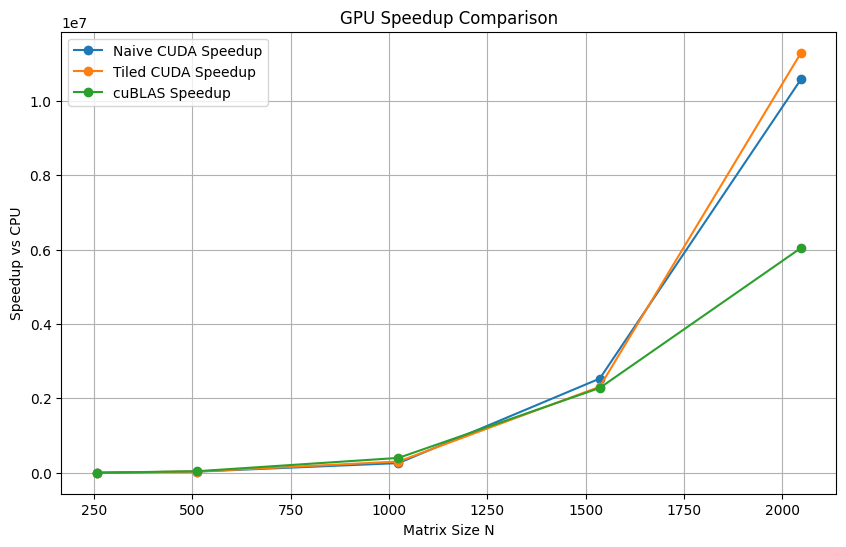

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results.csv")

plt.figure(figsize=(10,6))
plt.plot(df["N"], df["CPU_seconds"] / df["Naive_seconds"], marker="o", label="Naive CUDA Speedup")
plt.plot(df["N"], df["CPU_seconds"] / df["Tiled_seconds"], marker="o", label="Tiled CUDA Speedup")
plt.plot(df["N"], df["CPU_seconds"] / df["cuBLAS_seconds"], marker="o", label="cuBLAS Speedup")

plt.xlabel("Matrix Size N")
plt.ylabel("Speedup vs CPU")
plt.title("GPU Speedup Comparison")
plt.grid(True)
plt.legend()
plt.savefig("speedup_plot.png")
plt.show()


In [13]:
df = pd.read_csv("results.csv")
df


,N,CPU_seconds,Naive_seconds,Tiled_seconds,cuBLAS_seconds
0,256,0.022482,0.000043,0.000008,0.000078
1,512,0.248273,0.000008,0.000008,0.000006
2,1024,3.514921,0.000014,0.000012,0.000009
3,1536,19.775455,0.000008,0.000009,0.000009
4,2048,86.322658,0.000008,0.000008,0.000014


In [14]:
!nvidia-smi


Sun Nov 16 02:32:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             28W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----